### Let us Import all the libraries


In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests # to send requesto url
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if firt time 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if first time
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2t             |       h7b6447c_1         2.9 MB  anaconda
    zlib-1.2.11                |    h6eb9509_1006         123 KB  conda-forge
    sqlite-3.13.0              |                0         5.0 MB  anaconda
    setuptools-41.6.0          |           py36_1         627 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python-3.6.2               |                0        19.0 MB  anaconda
    pip-19.3.1       

<font size="5"> let us define function to rename detaframe colums

In [3]:
#define function to rename colunms 
def RenameDfColums(df, cList, start):
    iteration = len(cList)
    
    if (start+ iteration) > df.shape[1]:
        iteration = df.shape[1] - start 
    #print("Number of iteration",iteration, )
    
    Temp_df = df
    Temp_df.head()
    i = 0
    while i < iteration: 
        #print(i) 
        Temp_df.rename(columns={Temp_df.columns[start+i]:cList[i]},inplace = True) 
        i=i+1
        
    return (Temp_df)

<font size="5"> let us creat url for DFW zip code/city data  and Request the server to connect

In [4]:
#create url
url = 'https://www.zip-codes.com/state/tx.asp'

#Request web server to connect
Dallas_url = requests.get(url)
Dallas_url

<Response [200]>

<font size="5"> Read text from the url with read_html and find table with useful data

In [5]:
#Read_html
DFW_data = pd.read_html(Dallas_url.text,header =0)

In [6]:
#check how many tables are in the html
print('There are {} tables type of {}'.format(len(DFW_data), type(DFW_data)))

There are 4 tables type of <class 'list'>


<font size="5"> Take the table with zip code information 

In [7]:
Dfw_df = DFW_data[2]
Dfw_df.head()

,ZIP Code,City,County,Type
0,ZIP Code 73301,Austin,Travis,Unique
1,ZIP Code 73344,Austin,Travis,Unique
2,ZIP Code 73960,Texhoma,Sherman,P.O. Box
3,ZIP Code 75001,Addison,Dallas,Standard
4,ZIP Code 75002,Allen,Collin,Standard


<font size="5"> Drop "Type" column and rename "ZIP  Code" (ZipCode)

In [8]:
Dfw_df.drop(['Type'],axis=1, inplace=True)
RenameDfColums(Dfw_df, ['ZipCode','City','County'], 0)
Dfw_df.head()

,ZipCode,City,County
0,ZIP Code 73301,Austin,Travis
1,ZIP Code 73344,Austin,Travis
2,ZIP Code 73960,Texhoma,Sherman
3,ZIP Code 75001,Addison,Dallas
4,ZIP Code 75002,Allen,Collin


In [9]:
#create url for dfw population data
url = 'https://en.wikipedia.org/wiki/Dallas%E2%80%93Fort_Worth_metroplex'

#Request web server to connect
Dfw_url = requests.get(url)
DFW_pop = pd.read_html(Dfw_url.text,header =0)
#check how many tables are in the html
print('There are {} tables type of {}'.format(len(DFW_pop), type(DFW_pop)))

There are 22 tables type of <class 'list'>


In [20]:
Dfw_pop = DFW_pop[5]
Dfw_pop = Dfw_pop[['County', '2017 Estimate', '2010 Census']]
Dfw_pop.head()

,County,2017 Estimate,2010 Census
0,Collin County,969603,782341
1,Dallas County,2618148,2368139
2,Denton County,836210,662614
3,Ellis County,173620,149610
4,Hood County,58273,51182


In [26]:
Dfw_pop['Pop Change'] = ((100*(Dfw_pop['2017 Estimate'] - Dfw_pop['2010 Census'])/Dfw_pop['2010 Census'])).round(2).astype(str) + " %"
Dfw_pop.head()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,County,2017 Estimate,2010 Census,Pop Change
0,Collin County,969603,782341,23.94 %
1,Dallas County,2618148,2368139,10.56 %
2,Denton County,836210,662614,26.2 %
3,Ellis County,173620,149610,16.05 %
4,Hood County,58273,51182,13.85 %


In [28]:
#Sort data 
Dfw_pop=Dfw_pop.sort_values('2017 Estimate', ascending=False ).reset_index(drop=True)
Dfw_pop.head()

,County,2017 Estimate,2010 Census,Pop Change
0,Total,7399662,6426214,15.15 %
1,Dallas County,2618148,2368139,10.56 %
2,Tarrant County,2054475,1809034,13.57 %
3,Collin County,969603,782341,23.94 %
4,Denton County,836210,662614,26.2 %


Set county as index columns and plot horizontal bar graph to compare population growth 

In [29]:
dfwPop = Dfw_pop.set_index('County')
dfwPop.head()

,2017 Estimate,2010 Census,Pop Change
County,,,
Total,7399662,6426214,15.15 %
Dallas County,2618148,2368139,10.56 %
Tarrant County,2054475,1809034,13.57 %
Collin County,969603,782341,23.94 %
Denton County,836210,662614,26.2 %


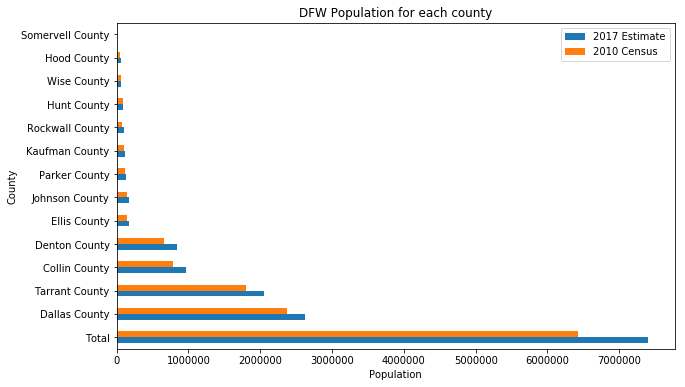

In [30]:
#plot
dfwPop.plot(kind='barh', figsize=(10, 6))
plt.ylabel('County') 
plt.xlabel('Population') 
plt.title('DFW Population for each county') 
plt.show()

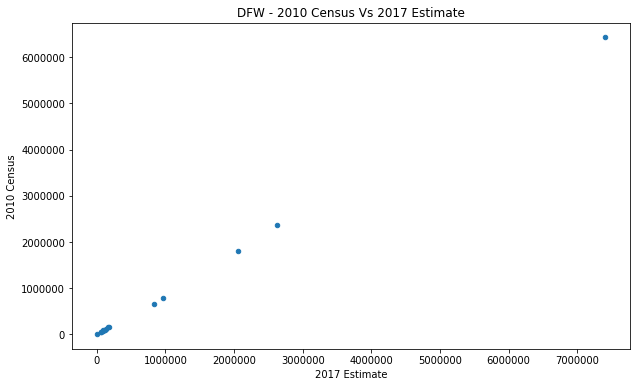

In [31]:
dfwPop.plot( x='2017 Estimate', y= '2010 Census', kind='scatter',figsize=(10, 6))
plt.xlabel('2017 Estimate') 
plt.ylabel('2010 Census') 
plt.title('DFW - 2010 Census Vs 2017 Estimate') 
plt.show()

<font size="5"> From the Bard graph the most populated counties are Dallas, Tarrant, collin and Denton. I'll use only these counties for the analysis

In [32]:
Counties = ['Collin', 'Dallas', 'Denton', 'Tarrant']
print(Dfw_df.shape)
#Counties = ['Collin', 'Dallas', 'Denton', 'Ellis', 'Hood', 'Hunt', 'Johnson', 'Kaufman', 'Parker', 'Rockwall', 'Somervell', 'Tarrant','Wise']
#Counties = ['Dallas', 'Tarrant']
Dfw_df = Dfw_df[Dfw_df['County'].isin(Counties)].reset_index(drop=True)
Dfw_df.head()

(2598, 3)


,ZipCode,City,County
0,ZIP Code 75001,Addison,Dallas
1,ZIP Code 75002,Allen,Collin
2,ZIP Code 75006,Carrollton,Dallas
3,ZIP Code 75007,Carrollton,Denton
4,ZIP Code 75009,Celina,Collin


In [33]:
Dfw_df.shape

(324, 3)

<font size="5"> Let us clean Zipcode values, keep only the Zipcode numbers

In [34]:
temp = pd.DataFrame(columns=['ZipCode'])

for list in Dfw_df['ZipCode']:
    temp['ZipCode']  = Dfw_df['ZipCode'].str.split().str[2]

Dfw_df['ZipCode'] = temp['ZipCode']
Dfw_df.head()

,ZipCode,City,County
0,75001,Addison,Dallas
1,75002,Allen,Collin
2,75006,Carrollton,Dallas
3,75007,Carrollton,Denton
4,75009,Celina,Collin


In [35]:
Dfw_df.shape

(324, 3)

<font size="4.5"> Let us Import Zipcode Latitude and longitude values 

In [37]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c82be60df18040c0b0d7bf9c4bb8d01d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='mGnyn4hi1QqfMAafQ09t5OxJ6OkyDb7TfvH8xbP-96kV',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_c82be60df18040c0b0d7bf9c4bb8d01d.get_object(Bucket='coursercapstone-donotdelete-pr-hsxcbguwbb7ryb',Key='All_us-zip-code-latitude-and-longitude.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ZipCode_df = pd.read_csv(body)
ZipCode_df.head()


ModuleNotFoundError: No module named 'botocore'

<font size="4"> Let us drop some of additional columns which are not relevant. Also, take zip codes for DFW area only (75001-76670)

In [506]:
# Creat Dfw_Zipcode dataframe which covers zipcodes only in DFW(75001 to 76670)
Dfw_ZipCode = ZipCode_df.loc[(ZipCode_df['Zip'] >= 75001) & (ZipCode_df['Zip'] <= 76670)].reset_index(drop=True)

Dfw_ZipCode.drop(['City','State'],axis=1, inplace=True)
Dfw_ZipCode.head()

,Zip,Latitude,Longitude
0,75475,33.485315,-96.25525
1,75757,32.136787,-95.36710
2,75010,33.030556,-96.89328
3,76054,32.858398,-97.17681
4,75961,31.626011,-94.60338


In [507]:
Dfw_ZipCode.shape

(946, 3)

<font size="4"> Rename Zip to ZipCode

In [508]:
RenameDfColums(Dfw_ZipCode, ['ZipCode'], 0)
Dfw_ZipCode.head()

,ZipCode,Latitude,Longitude
0,75475,33.485315,-96.25525
1,75757,32.136787,-95.36710
2,75010,33.030556,-96.89328
3,76054,32.858398,-97.17681
4,75961,31.626011,-94.60338


In [509]:
Dfw_ZipCode.shape

(946, 3)

<font size="4"> Check data type for each dataframes before merging them

In [510]:
print(Dfw_ZipCode.dtypes)
print(Dfw_df.dtypes)

ZipCode        int64
Latitude     float64
Longitude    float64
dtype: object
ZipCode    object
City       object
County     object
dtype: object


Let Us change Zipcode data type int64

In [511]:
Dfw_df['ZipCode'] = Dfw_df['ZipCode'].astype(int)
print(Dfw_df.dtypes)

ZipCode     int64
City       object
County     object
dtype: object


<font size="4"> Inner joint the two dataframes and create Dfw_data 

In [512]:
#Dfw_data = pd.merge(Dfw_df, Dfw_ZipCode, on='ZipCode',how='inner')
Dfw_data = pd.merge(Dfw_df, Dfw_ZipCode, on='ZipCode')
Dfw_data.head()

,ZipCode,City,County,Latitude,Longitude
0,75001,Addison,Dallas,32.961290,-96.837510
1,75006,Carrollton,Dallas,32.960374,-96.891630
2,75011,Carrollton,Dallas,32.767268,-96.777626
3,75014,Irving,Dallas,32.767268,-96.777626
4,75015,Irving,Dallas,32.767268,-96.777626


In [513]:
print (Dfw_data.shape)
print (Dfw_df.shape)
print (Dfw_ZipCode.shape)

(255, 5)
(259, 3)
(946, 3)


In [514]:
Dfw_data['City'] = Dfw_data['City'] + "_" + Dfw_data['ZipCode'].apply(str)
Dfw_data.head()

,ZipCode,City,County,Latitude,Longitude
0,75001,Addison_75001,Dallas,32.961290,-96.837510
1,75006,Carrollton_75006,Dallas,32.960374,-96.891630
2,75011,Carrollton_75011,Dallas,32.767268,-96.777626
3,75014,Irving_75014,Dallas,32.767268,-96.777626
4,75015,Irving_75015,Dallas,32.767268,-96.777626


In [515]:
Dfw_data.dtypes

ZipCode        int64
City          object
County        object
Latitude     float64
Longitude    float64
dtype: object

In [516]:
Dfw_data['ZipCode'] = Dfw_data['ZipCode'].astype(object)
print(Dfw_data.dtypes)

ZipCode       object
City          object
County        object
Latitude     float64
Longitude    float64
dtype: object


### Let us explore Dallas, TX 

In [517]:
address = 'Dallas, TX'

geolocator = Nominatim(user_agent="Dallas_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of dallas are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of dallas are 32.7762719, -96.7968559.


In [518]:
#create map of Dallas using latitude and longitude values
map_Dfw = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, City, ZipCode in zip(Dfw_data['Latitude'], Dfw_data['Longitude'], Dfw_data['City'], Dfw_data['ZipCode']):
    label = '{}, {}'.format(City, ZipCode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_Dfw)  
    
map_Dfw

In [519]:
Dfw_data.loc[0, 'City']

'Addison_75001'

In [520]:
City_latitude = Dfw_data.loc[0, 'Latitude'] # City latitude value
City_longitude = Dfw_data.loc[0, 'Longitude'] # City longitude value

City_name = Dfw_data.loc[0, 'City'] # neighborhCityood name

print('Latitude and longitude values of {} are {}, {}.'.format(City_name, 
                                                               City_latitude, 
                                                               City_longitude))

Latitude and longitude values of Addison_75001 are 32.961290000000005, -96.83751.


In [522]:
# @hidden_cell
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

CLIENT_ID = 'H35WBOM2TBROL12M2GQL2P0DCZ5VX1HTQYW3D4CZXWO1X3QI' # your Foursquare ID
CLIENT_SECRET = 'SJXU4NOZTLFGMDIYMQVPMUR2GJWJO1SSCWJ0I5MBXG1IGT51' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    City_latitude, 
    City_longitude, 
    radius, 
    LIMIT)

In [523]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dcdbd6b0de0d9001c0d57e2'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Dallas',
  'headerFullLocation': 'Dallas',
  'headerLocationGranularity': 'city',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 32.96579000450001,
    'lng': -96.83215672561215},
   'sw': {'lat': 32.9567899955, 'lng': -96.84286327438784}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4afd9354f964a520bb2822e3',
       'name': "Cindi's N.Y. Delicatessen",
       'location': {'address': '2001 Midway Rd Ste 132',
        'crossStreet': 'btwn Midcourt Rd. & Wiley Post Rd.',
        'lat': 32.96186353703873,
        'lng': -96.83887266048376,
        'labeledLatL

In [524]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [525]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Cindi's N.Y. Delicatessen,Diner,32.961864,-96.838873
1,La Spiga,Bakery,32.958278,-96.837417
2,Enterprise Rent-A-Car,Rental Car Location,32.960673,-96.838102
3,Dallas Desk,Furniture / Home Store,32.957869,-96.838840
4,Childress Fabrics,Arts & Crafts Store,32.957012,-96.838939


In [526]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


In [527]:

def getNearbyVenues(names, latitudes, longitudes, radius=250):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [528]:
Dfw_venues_raw = getNearbyVenues(names=Dfw_data['City'],
                                   latitudes=Dfw_data['Latitude'],
                                   longitudes=Dfw_data['Longitude']
                                  )

Addison_75001
Carrollton_75006
Carrollton_75011
Irving_75014
Irving_75015
Irving_75016
Irving_75017
Coppell_75019
Rowlett_75030
Irving_75038
Irving_75039
Garland_75040
Garland_75041
Garland_75042
Garland_75043
Garland_75044
Garland_75045
Garland_75046
Garland_75047
Sachse_75048
Garland_75049
Grand Prairie_75050
Grand Prairie_75051
Grand Prairie_75052
Grand Prairie_75053
Grand Prairie_75054
Irving_75059
Irving_75060
Irving_75061
Irving_75062
Irving_75063
Richardson_75080
Richardson_75081
Richardson_75082
Richardson_75083
Richardson_75085
Rowlett_75088
Rowlett_75089
Coppell_75099
Cedar Hill_75104
Cedar Hill_75106
Desoto_75115
Duncanville_75116
Desoto_75123
Lancaster_75134
Duncanville_75137
Duncanville_75138
Hutchins_75141
Lancaster_75146
Mesquite_75149
Mesquite_75150
Seagoville_75159
Wilmer_75172
Balch Springs_75180
Mesquite_75181
Sunnyvale_75182
Mesquite_75185
Mesquite_75187
Dallas_75201
Dallas_75202
Dallas_75203
Dallas_75204
Dallas_75205
Dallas_75206
Dallas_75207
Dallas_75208
Dallas_75

In [529]:
print(Dfw_venues_raw.shape)
Dfw_venues_raw.head()

(454, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addison_75001,32.961290,-96.83751,Cindi's N.Y. Delicatessen,32.961864,-96.838873,Diner
1,Addison_75001,32.961290,-96.83751,Enterprise Rent-A-Car,32.960673,-96.838102,Rental Car Location
2,Addison_75001,32.961290,-96.83751,Skyline Trapeze,32.961506,-96.837273,Athletics & Sports
3,Addison_75001,32.961290,-96.83751,Septien Entertainment Group,32.962329,-96.839551,Performing Arts Venue
4,Carrollton_75006,32.960374,-96.89163,Barnes & Noble,32.959041,-96.890362,Bookstore


In [530]:
Dfw_venues_raw.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Addison_75001,4,4,4,4,4,4
Arlington_76003,1,1,1,1,1,1
Arlington_76006,4,4,4,4,4,4
Arlington_76010,1,1,1,1,1,1
Arlington_76011,2,2,2,2,2,2
Arlington_76012,11,11,11,11,11,11
Arlington_76013,18,18,18,18,18,18
Arlington_76015,2,2,2,2,2,2
Arlington_76016,2,2,2,2,2,2


Let us use cities with venues higher than 5

In [600]:
Dfw_venues = Dfw_venues_raw.groupby('City').filter(lambda x : len(x)>0)
Dfw_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Addison_75001,4,4,4,4,4,4
Arlington_76003,1,1,1,1,1,1
Arlington_76006,4,4,4,4,4,4
Arlington_76010,1,1,1,1,1,1
Arlington_76011,2,2,2,2,2,2
Arlington_76012,11,11,11,11,11,11
Arlington_76013,18,18,18,18,18,18
Arlington_76015,2,2,2,2,2,2
Arlington_76016,2,2,2,2,2,2


<font size="4"> Let us create one hot encoder object

In [601]:
# one hot encoding
Dfw_onehot = pd.get_dummies(Dfw_venues[['Venue Category']], prefix="", prefix_sep="")

# add City column back to dataframe
Dfw_onehot['City'] = Dfw_venues['City'] 

# move City column to the first column
cls = Dfw_onehot.columns[:-1]
cls = cls.tolist()

fixed_columns = [Dfw_onehot.columns[-1]] + cls
Dfw_onehot = Dfw_onehot[fixed_columns]

Dfw_onehot.head()

,City,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Line,Business Service,Café,Cajun / Creole Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Donut Shop,Dry Cleaner,Electronics Store,Farm,Fast Food Restaurant,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Hockey Field,Home Service,Hotel,Hotel Pool,Housing Development,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Latin American Restaurant,Lawyer,Liquor Store,Locksmith,Lounge,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Pool,Public Art,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shop & Service,Smoke Shop,Smoothie Shop,Soccer Field,Spa,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wings Joint
0,Addison_75001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Addison_75001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Addison_75001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addison_75001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Carrollton_75006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [602]:
Dfw_onehot.shape

(454, 144)

<font size="4"> Group venues by city

In [603]:
Dfw_grouped = Dfw_onehot.groupby('City').mean().reset_index()
Dfw_grouped

,City,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Line,Business Service,Café,Cajun / Creole Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Donut Shop,Dry Cleaner,Electronics Store,Farm,Fast Food Restaurant,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Hockey Field,Home Service,Hotel,Hotel Pool,Housing Development,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Latin American Restaurant,Lawyer,Liquor Store,Locksmith,Lounge,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Pool,Public Art,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shop & Service,Smoke Shop,Smoothie Shop,Soccer Field,Spa,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wings Joint
0,Addison_75001,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arlington_76003,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00

In [604]:
Dfw_grouped.shape

(101, 144)

<font size="4">  Let us check top 5 venues for each city

In [605]:
num_top_venues = 5

for hood in Dfw_grouped['City']:
    print("----"+hood+"----")
    temp = Dfw_grouped[Dfw_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Addison_75001----
                   venue  freq
0                  Diner  0.25
1  Performing Arts Venue  0.25
2    Rental Car Location  0.25
3     Athletics & Sports  0.25
4         Adult Boutique  0.00


----Arlington_76003----
             venue  freq
0              Bar   1.0
1   Adult Boutique   0.0
2  Motorcycle Shop   0.0
3      Music Venue   0.0
4       Nail Salon   0.0


----Arlington_76006----
                                      venue  freq
0                              Cupcake Shop  0.25
1                                Food Truck  0.25
2                              Hockey Field  0.25
3  Residential Building (Apartment / Condo)  0.25
4                              Optical Shop  0.00


----Arlington_76010----
            venue  freq
0    Home Service   1.0
1  Adult Boutique   0.0
2    Optical Shop   0.0
3     Music Venue   0.0
4      Nail Salon   0.0


----Arlington_76011----
            venue  freq
0            Park   0.5
1  Baseball Field   0.5
2  Adult Boutique   0.

<font size="4"> Define a function to return top venues

In [606]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [607]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
City_venues_sorted = pd.DataFrame(columns=columns)
City_venues_sorted['City'] = Dfw_grouped['City']

for ind in np.arange(Dfw_grouped.shape[0]):
    City_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Dfw_grouped.iloc[ind, :], num_top_venues)

City_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addison_75001,Performing Arts Venue,Diner,Rental Car Location,Athletics & Sports,Doctor's Office,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner
1,Arlington_76003,Bar,Wings Joint,Fried Chicken Joint,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop
2,Arlington_76006,Food Truck,Hockey Field,Cupcake Shop,Residential Building (Apartment / Condo),Donut Shop,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner
3,Arlington_76010,Home Service,Donut Shop,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office,Fried Chicken Joint
4,Arlington_76011,Park,Baseball Field,Wings Joint,Dry Cleaner,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Donut Shop


In [608]:
City_venues_sorted.shape

(101, 11)

## Clustering City

<font size="4"> We'll run k-means to cluster the cities into 5 clusters

In [639]:
# set number of clusters
kclusters = 5

Dfw_grouped_clustering = Dfw_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Dfw_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 0, 1, 2, 2, 3, 2, 2], dtype=int32)

<font size="4"> Let's create a new dataframe that includes the cluster as well as the top 10 venues for each city

In [640]:
# add clustering labels

City_venues_sorted.drop(columns=['Cluster Labels'],inplace= True)
City_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Dfw_Merged = Dfw_data

# merge Dfw_grouped with Dfw_data to add latitude/longitude for each neighborhood
Dfw_Merged = Dfw_Merged.join(City_venues_sorted.set_index('City'), on='City', how = 'inner')

Dfw_Merged.head()

,ZipCode,City,County,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75001,Addison_75001,Dallas,32.961290,-96.83751,2,Performing Arts Venue,Diner,Rental Car Location,Athletics & Sports,Doctor's Office,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner
1,75006,Carrollton_75006,Dallas,32.960374,-96.89163,2,Bookstore,Wings Joint,Convenience Store,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop
9,75038,Irving_75038,Dallas,32.872386,-96.98524,2,Medical Supply Store,Business Service,Wings Joint,Fried Chicken Joint,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner
10,75039,Irving_75039,Dallas,32.876474,-96.94129,2,Hotel Pool,Tex-Mex Restaurant,Gastropub,Mexican Restaurant,Rental Car Location,Hotel,Arts & Crafts Store,Fried Chicken Joint,Dessert Shop,Diner
11,75040,Garland_75040,Dallas,32.920574,-96.62639,2,Warehouse Store,Gas Station,Fast Food Restaurant,Wings Joint,Donut Shop,Food Truck,Fondue Restaurant,Farm,Electronics Store,Dry Cleaner


In [641]:
#Dfw_Merged.drop(['City'],axis=1, inplace=True)
#Dfw_Merged.head()

In [642]:
#RenameDfColums(Dfw_Merged, ['City'], 0)
#Dfw_Merged.head()

In [643]:
#Dfw_Merged = Dfw_Merged.join(City_venues_sorted.set_index('City'), on='City', how = 'inner')
#Dfw_Merged.head()

In [644]:
#Dfw_Merged.dropna(inplace = True)
print(Dfw_Merged.shape)
print(Dfw_data.shape)
print(City_venues_sorted.shape)

(101, 16)
(255, 5)
(101, 12)


In [645]:
#Dfw_Merged['Cluster Labels'] = Dfw_Merged['Cluster Labels'].astype(int)
#Dfw_Merged['Cluster Labels'].dtypes

<font size="4">Finally, let's visualize the resulting clusters

In [646]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Dfw_Merged['Latitude'], Dfw_Merged['Longitude'], Dfw_Merged['City'], Dfw_Merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

<font size="4"> Let's examine the clusters and undertand what are the dicriminating vanue categories that distinguish each cluster. 

In [647]:
List = [*range(5, Dfw_Merged.shape[1])]
List

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

<font size="4"> Cluster one is with convenience store as it's 1st most commone venue and Lawyer office as 2nd most common vanue. which indicates, the City of Grand Prairie is living area with recreation options like baseball and performing arts.  

In [648]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 0, Dfw_Merged.columns[[1] + List]]#cluster 1

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Dallas_75205,0,Construction & Landscaping,Home Service,American Restaurant,Dry Cleaner,French Restaurant,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store
73,Dallas_75217,0,Home Service,Donut Shop,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office,Fried Chicken Joint
167,Arlington_76010,0,Home Service,Donut Shop,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office,Fried Chicken Joint
178,Bedford_76021,0,Home Service,Chinese Restaurant,Donut Shop,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office
254,Keller_76248,0,Home Service,Locksmith,Fried Chicken Joint,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop


<font size="4"> Cluster two contains the highly dense part of the city the like of Dallas, irving, and plano.  These are the area where different restaurants are as 1st, 2nd, 3rd and 4th most common venues. Any one who is interested opening restaurant should consider one this cities. 

In [649]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 1, Dfw_Merged.columns[[1] + List]] #cluster  2

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Garland_75042,1,Park,Music Venue,Optical Shop,Business Service,Wings Joint,Donut Shop,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner
28,Irving_75061,1,Park,Convenience Store,Fast Food Restaurant,Donut Shop,Food Truck,Fondue Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office
61,Dallas_75204,1,Park,Fast Food Restaurant,Wings Joint,Donut Shop,Food Truck,Fondue Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office
84,Dallas_75228,1,Park,Dessert Shop,Sandwich Place,Convenience Store,Wings Joint,Dry Cleaner,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store
168,Arlington_76011,1,Park,Baseball Field,Wings Joint,Dry Cleaner,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Donut Shop
197,Fort Worth_76103,1,Park,Wings Joint,Donut Shop,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office
204,Fort Worth_76110,1,Convenience Store,Art Gallery,Park,Mexican Restaurant,Health & Beauty Service,Hardware Store,Deli / Bodega,Herbs & Spices Store,Dessert Shop,Diner
217,Fort Worth_76123,1,Bike Rental / Bike Share,Park,Dry Cleaner,French Restaurant,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Donut Shop
229,Fort Worth_76137,1,Park,Other Repair Shop,Wings Joint,Doctor's Office,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop


In [650]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 2, Dfw_Merged.columns[[1] + List]]#cluster 3

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addison_75001,2,Performing Arts Venue,Diner,Rental Car Location,Athletics & Sports,Doctor's Office,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner
1,Carrollton_75006,2,Bookstore,Wings Joint,Convenience Store,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop
9,Irving_75038,2,Medical Supply Store,Business Service,Wings Joint,Fried Chicken Joint,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner
10,Irving_75039,2,Hotel Pool,Tex-Mex Restaurant,Gastropub,Mexican Restaurant,Rental Car Location,Hotel,Arts & Crafts Store,Fried Chicken Joint,Dessert Shop,Diner
11,Garland_75040,2,Warehouse Store,Gas Station,Fast Food Restaurant,Wings Joint,Donut Shop,Food Truck,Fondue Restaurant,Farm,Electronics Store,Dry Cleaner
12,Garland_75041,2,Burger Joint,Wings Joint,Convenience Store,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop
14,Garland_75043,2,Herbs & Spices Store,Neighborhood,Wings Joint,Donut Shop,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office
15,Garland_75044,2,Fast Food Restaurant,Wings Joint,Donut Shop,Food Truck,Fondue Restaurant,Farm,Electronics Store,Dry Cleaner,Doctor's Office,Fried Chicken Joint
19,Sachse_75048,2,Greek Restaurant,Wings Joint,Fried Chicken Joint,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop
21,Grand Prairie_75050,2,Convenience Store,Insurance Office,Lawyer,Performing Arts Venue,Hardware Store,Gymnastics Gym,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner


In [651]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 3, Dfw_Merged.columns[[1] + List]]#cluster 4

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Dallas_75212,3,Locksmith,Wings Joint,Fried Chicken Joint,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop
172,Arlington_76015,3,Locksmith,Wings Joint,Fried Chicken Joint,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop
179,Bedford_76022,3,Locksmith,Wings Joint,Fried Chicken Joint,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Donut Shop


In [652]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 4, Dfw_Merged.columns[[1] + List]]#cluster 5

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Mesquite_75149,4,Mexican Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Wings Joint
83,Dallas_75227,4,Mexican Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Wings Joint
183,Euless_76040,4,Mexican Restaurant,Gymnastics Gym,Wings Joint,Donut Shop,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner
205,Fort Worth_76111,4,Mexican Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Fondue Restaurant,Fast Food Restaurant,Farm,Electronics Store,Dry Cleaner,Wings Joint


In [653]:
#Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 5, Dfw_Merged.columns[[1] + List]]#cluster 6

In [654]:
#Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 6, Dfw_Merged.columns[[1] + List]]#cluster 7

In [655]:
#Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 7, Dfw_Merged.columns[[1] + List]]#cluster 8

In [656]:
#Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 8, Dfw_Merged.columns[[1] + List]]#cluster 9